# PMT Pulse analysis

Jelle, 20 January 2019

Standard python setup:

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100

After this standard setup, we can load straxen:

In [2]:
import straxen
st = straxen.contexts.xenon1t_analysis()

Unfortunately LED runs have not been converted to strax yet, so we'll have to make due with a background run for now. Of course you can't really do gain calibration on that, but it's the best we can do for the moment.

Let's select the earliest background run of SR1 for which we have strax data. (taking the last would have made more sense, except our database is currently corrupted for many runs, this one at least works...)

In [3]:
dsets = st.run_selection(available='raw_records', 
                         include_tags='sciencerun1',
                         run_mode='background_stable')
run_id = dsets.name.min()
run_id

Checking data availability: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


'170215_1657'

This run is one hour long, so the full raw waveform data won't fit into memory. Let's instead load only the first 30 seconds. This is at the moment slightly clunky:

In [4]:
# Get the first timestamp from the data
t0 = st.get_meta(run_id, 'raw_records')['chunks'][0]['first_time']

# Load the first thirty seconds
rr = st.get_array(run_id, 'raw_records', 
                  time_range=(t0, t0 + int(30e9)))

Not saving raw_records while selecting a time range in the run


The `rr` object is just a dataframe, except stored in a somewhat more low-level format (numpy structured array) rather than a pandas dataframe. However, you can use the same syntax you're used to from dataframes for selections.

Here are the fields you can access:

In [5]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,channel,int16,Channel/PMT number
1,dt,int16,Time resolution in ns
2,time,int64,Start time of the interval (ns since unix epoch)
3,length,int32,Length of the interval in samples
4,area,int32,Integral in ADC x samples
5,pulse_length,int32,Length of pulse to which the record belongs (without zero-padding)
6,record_i,int16,Fragment number in the pulse
7,baseline,float32,Baseline in ADC counts. data = int(baseline) - data_orig
8,reduction_level,uint8,Level of data reduction applied (strax.ReductionLevel enum)
9,data,"('<i2', (110,))",Waveform data in ADC counts above baseline


Let's select only records that belong to short PMT pulses. These are mostly lone PMT hits. Longer pulses are likely part of S1s or S2s.

In [6]:
rr = rr[rr['pulse_length'] < 110]

You now have a matrix (record_i, sample_j) of waveforms in rr['data']:

In [7]:
rr['data'].shape

(1703986, 110)

Here's one record:

Text(0,0.5,'Amplitude (ADCc)')

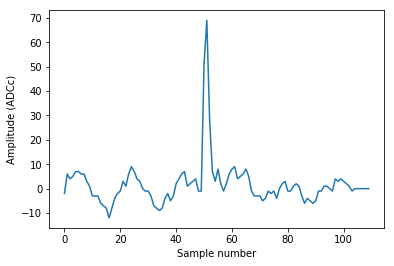

In [8]:
plt.plot(rr['data'][0])
plt.xlabel("Sample number")
plt.ylabel("Amplitude (ADCc)")

As you can see, this is a single PE pulse. The baseline is already subtracted (and the pulse has been flipped), but no other operations have been done on it.

Let's focus on channel 100 for now:

In [9]:
r = rr[rr['channel'] == 100]

## Pulse shape

Here is the distribution of amplitudes in each sample. This is very roughly the mean pulse shap:

Text(0,0.5,'Amplitude (ADCc)')

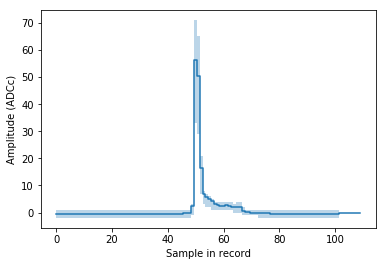

In [10]:
ns = np.arange(len(r['data'][0]))
plt.plot(ns, r['data'].mean(axis=0), linestyle='steps-mid')
plt.fill_between(
    ns,
    np.percentile(r['data'], 25, axis=0),
    np.percentile(r['data'], 75, axis=0), 
    step='mid', alpha=0.3, linewidth=0)
plt.xlabel("Sample in record")
plt.ylabel("Amplitude (ADCc)")

You can clearly see we're dealing with single PEs here, and also see the infamous long PE pulse tail. For a serious pulse shape study you should of course first normalize the pulses.

## Gain calibration

Let's integrate between sample 40 and 70:

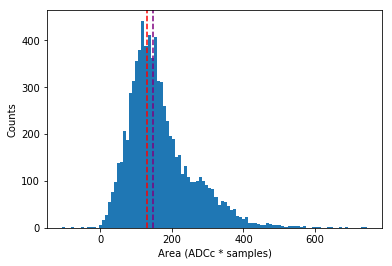

In [11]:
areas = r['data'][:,40:70].sum(axis=1)

plt.hist(areas, bins=100)
plt.xlabel("Area (ADCc * samples)")
plt.ylabel("Counts")
plt.axvline(1/straxen.to_pe[100], color='r', linestyle='--')
plt.axvline(np.median(areas), color='purple', linestyle='--')

The red line indicates where the 1 PE area should be according to the XENON1T gain calibration. Looks like the gain is correct for this PMT!

The purple line is an extremely bad gain estimate (the median area) of pulses, which nonetheless comes close for this PMT. It should be obvious this is a bad method: it takes no account of 2PE hits at all.

Let's do the same for all PMTs:

In [12]:
areas = rr['data'][:,40:70].sum(axis=1)
channels = rr['channel']

gain_ests = np.array([
    np.median(areas[channels == pmt]) 
    for pmt in tqdm(np.arange(248))])

 12%|█▏        | 30/248 [00:00<00:03, 55.27it/s]/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 248/248 [00:04<00:00, 55.61it/s]


/home/aalbers/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


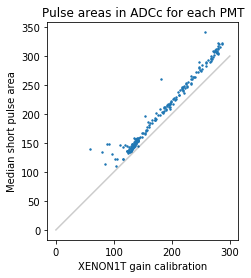

In [13]:
plt.scatter(1/straxen.to_pe[:248], gain_ests, s=2)
plt.plot([0, 300], [0, 300], c='k', alpha=0.2)
plt.xlabel("XENON1T gain calibration")
plt.ylabel("Median short pulse area")
plt.title("Pulse areas in ADCc for each PMT")
plt.gca().set_aspect('equal')

As you can see, even this extremely basic method (median area of short pulses in 30sec of background data) gives a reasonable, although biased, gain estimate for most PMTs.

If you're planning to do serious work on gains with strax, make sure somebody fixes https://github.com/AxFoundation/strax/issues/2 first, or your gains will come out systematically too low (try e.g. increasing the integration window above to check this).